Here is the library of functions:

In [12]:
def logistic(x):
    '''
    '''
    return 1/(1+np.exp(-x))

def U_logistic(theta, Y, X, phi):
    '''
    '''
    return - (Y.T @ X @ theta - np.sum(np.log(1+np.exp(X @ theta))) - 0.5 * phi * np.sum(theta**2))

def gradU_logistic(theta, Y, X, phi):
    '''
    '''
    n = X.shape[0]
    
    Y_pred = logistic(X @ theta)
    epsilon = (Y[:,np.newaxis] - Y_pred[:,np.newaxis])
    grad = X.T @ epsilon - phi * theta[:, np.newaxis]

    return -grad/n


def hmc(Y, X, U, gradU, M, eps, m, theta0, phi):
    '''
    '''
    theta = theta0.copy()
    n, p = X.shape
    
    # Precompute
    Minv = np.linalg.inv(M)
    
    # Randomly sample momentum
    r = np.random.multivariate_normal(np.zeros(p),M)[:,np.newaxis]
    
    # Intial energy
    H0 = U(theta0, Y, X, phi) + 0.5 * np.asscalar(r.T @ Minv @ r)
    
    # Hamiltonian dynamics
    r -= (eps/2)*gradU(theta, Y, X, phi)
    for i in range(m):
        theta += (eps*Minv@r).ravel()
        r -= eps*gradU(theta, Y, X, phi)
    r -= (eps/2)*gradU(theta, Y, X, phi)
    
    # Final energy
    H1 = U(theta, Y, X, phi) + np.asscalar(0.5 * r.T @ Minv @ r)
    
    # MH step
    u = np.random.uniform()
    rho = np.exp(H0 - H1) # Acceptance probability
    
    if u < np.min((1, rho)):
        # accept
        accept = True
        H = H1
    else:
        # reject
        theta = theta0
        accept = False
        H = H0

    return theta, accept, rho, H


def run_hmc(Y, X, U, gradU, M, eps, m, theta, phi, nsample):

    n, p = X.shape
    
    # Allocate space
    samples = np.zeros((nsample, p))
    accept = np.zeros(nsample)
    rho = np.zeros(nsample)
    H = np.zeros(nsample)
    
    # Run hmc
    for i in range(nsample):
        theta, accept[i], rho[i], H[i] = hmc(Y, X, U, gradU, M, eps, m, theta, phi)
        samples[i] = theta
        
    return samples, accept, rho, H  

def stogradU(theta, Y, X, nbatch, phi):
    '''A function that returns the stochastic gradient. Adapted from Eq. 5.
    Inputs are:
        theta, the parameters
        Y, the response
        X, the covariates
        nbatch, the number of samples to take from the full data
    '''
    n, p = X.shape
    
    # Sample minibatch
    batch_id = np.random.choice(np.arange(n),nbatch,replace=False)
    
    Y_pred = logistic(X[batch_id,:] @ theta[:,np.newaxis])
    epsilon = (Y[batch_id,np.newaxis] - Y_pred)
    grad = n/nbatch * X[batch_id,:].T @ epsilon - phi * theta[:, np.newaxis]

    #return -grad/n
    return -grad

def sghmc(Y, X, U, gradU, M, Minv, eps, m, theta, B, D, phi):
    
    n, p = X.shape
    
    # Randomly sample momentum
    r = np.random.multivariate_normal(np.zeros(p),M)[:,np.newaxis]
    #r = np.zeros((p,1))
    
    # Hamiltonian dynamics
    for i in range(m): 
        theta += (eps*Minv@r).ravel()
        r -= eps*stogradU(theta, Y, X, nbatch,phi) - eps*C @ Minv @ r \
            + np.random.multivariate_normal(np.zeros(p),D)[:,np.newaxis] 
    
    # Record the energy
    H = U(theta, Y, X, phi) + np.asscalar(0.5 * r.T @ Minv @ r)
    
    return theta, H

def run_sghmc(Y, X, U, gradU, M, eps, m, theta, C, V, phi, nsample):
    n, p = X.shape
    
    # Precompute
    Minv = np.linalg.inv(M)
    B = 0.5 * V * eps
    D = 2*(C-B)*eps
    
    # Allocate space
    samples = np.zeros((nsample, p))
    H = np.zeros(nsample)
    
    # Run sghmc
    for i in range(nsample):
        theta, H[i] = sghmc(Y, X, U, gradU, M, Minv, eps, m, theta, B, D, phi)
        samples[i] = theta
        
    return samples, H
    
    
def gd(Y, X, gradU, eps, m, theta, phi):
    '''
    '''
    samples = np.zeros((nsample, p))
    
    for i in range(m):
        theta -= eps*gradU(theta, Y, X, phi).ravel()
      
    return theta     

In [2]:
import os
if not os.path.exists('./eigen'):
    ! git clone https://github.com/RLovelett/eigen.git

In [20]:
import cppimport
import numpy as np
import matplotlib.pyplot as plt

In [1]:
%%file wrap.cpp
<%
cfg['compiler_args'] = ['-std=c++11']
cfg['include_dirs'] = ['./eigen']
setup_pybind11(cfg)
%>

#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>
#include <pybind11/eigen.h>
#include <Eigen/Cholesky>

#include <random>
#include <algorithm>
#include <iterator>
#include <iostream>

namespace py = pybind11;

Eigen::VectorXd logistic(Eigen::VectorXd x) {
    return 1.0/(1.0 + exp((-x).array()));
}

Eigen::VectorXd gd(Eigen::MatrixXd X, Eigen::VectorXd y, Eigen::VectorXd beta, double alpha, int niter) {
    int n = X.rows();
    
    Eigen::VectorXd y_pred;
    Eigen::VectorXd resid;
    Eigen::VectorXd grad;
    Eigen::MatrixXd Xt = X.transpose();
            
    for (int i=0; i<niter; i++) {
        y_pred = logistic(X * beta);
        resid = y - y_pred;
        grad = Xt * resid / n;
        beta = beta + alpha * grad;
    }
    return beta;
}
   
Eigen::MatrixXd mvnorm(Eigen::VectorXd mu, Eigen::MatrixXd Sigma, int n) {
    //std::default_random_engine gen;
    std::default_random_engine gen(std::random_device{}());
    std::normal_distribution<double> distribution(0, 1);    
    
    Eigen::MatrixXd A(Sigma.llt().matrixL());
    int p = mu.size();
    Eigen::MatrixXd Z(n,p);  
            
    for(int i=0; i<n; i++) {
        Eigen::VectorXd v(p);
        for(int j=0; j<p; j++){
            v[j] = distribution(gen);
        }
        Z.row(i) = mu + A*v;
    }
    return Z;          
}
    
    
    
/*    
std::unordered_set<int> pickSet(int N, int k, std::mt19937& gen)
{
    std::uniform_int_distribution<> dis(1, N);
    std::unordered_set<int> elems;

    while (elems.size() < k) {
        elems.insert(dis(gen));
    }

    return elems;
} 
*/

/*
std::unordered_set<int> pickSet(int N, int k, std::mt19937& gen)
{
    std::unordered_set<int> elems;
    for (int r = N - k; r < N; ++r) {
        int v = std::uniform_int_distribution<>(1, r)(gen);

        // there are two cases.
        // v is not in candidates ==> add it
        // v is in candidates ==> well, r is definitely not, because
        // this is the first iteration in the loop that we could've
        // picked something that big.

        if (!elems.insert(v).second) {
            elems.insert(r);
        }   
    }
    return elems;
}
*/

std::unordered_set<int> pickSet(int N, int k, std::mt19937& gen)
{
    // Index of random rows to take.
    std::unordered_set<int> sample;
    std::default_random_engine generator;

    for(int d = N - k; d < N; d++) {
        int t = std::uniform_int_distribution<>(0, d)(generator);
        if (sample.find(t) == sample.end()) {
            sample.insert(t);
        } else {
            sample.insert(d);
        }
    }
    return sample;
}


std::vector<int> pick(int N, int k) {
    std::random_device rd;
    std::mt19937 gen(rd());

    std::unordered_set<int> elems = pickSet(N, k, gen);

    // ok, now we have a set of k elements. but now
    // it's in a [unknown] deterministic order.
    // so we have to shuffle it:

    //std::vector<int> result(vals.begin(), vals.end());
    std::vector<int> result(elems.begin(), elems.end());
    std::shuffle(result.begin(), result.end(), gen);
    return result;
}
    
    
    
    
    

/*
Eigen::VectorXd stogradU_logistic(Eigen::VectorXd theta, Eigen::VectorXd Y, Eigen::MatrixXd X, int nbatch, double phi) {
    // currently this does no random sampling
    int n = X.rows();            
                
    Eigen::VectorXd Y_pred;
    Eigen::VectorXd epsilon;
    Eigen::VectorXd grad;
    Eigen::MatrixXd Xt = X.transpose();
                
    Y_pred = logistic(X * theta);
    epsilon = Y - Y_pred;
    grad = n/nbatch * Xt * epsilon - phi * theta;

    return -grad;
}
*/

Eigen::VectorXd stogradU_logistic(Eigen::VectorXd theta, Eigen::VectorXd Y, Eigen::MatrixXd X, int nbatch, double phi) {
    // currently this does no random sampling
    int n = X.rows();
    int p = X.cols();
    
    // Allocate
    Eigen::MatrixXd Xsamp = Eigen::MatrixXd::Zero( nbatch, p ); 
    Eigen::VectorXd Ysamp = Eigen::VectorXd::Zero( nbatch );            
    Eigen::VectorXd Y_pred;
    Eigen::VectorXd epsilon;
    Eigen::VectorXd grad;
            
    std::vector<int> r = pick(n, nbatch);
            
    for(int i=0; i<nbatch; i++) {
        Xsamp.row(i) = X.row(r[i]-1);
        Ysamp.row(i) = Y.row(r[i]-1);
    }        
            
            
    Eigen::MatrixXd Xsampt = Xsamp.transpose();
                
    Y_pred = logistic(Xsamp * theta);
    epsilon = Ysamp - Y_pred;
    grad = n/nbatch * Xsampt * epsilon - phi * theta;

    return -grad;
}
        
Eigen::VectorXd sghmc_opt(Eigen::VectorXd Y, Eigen::MatrixXd X, Eigen::MatrixXd M, Eigen::MatrixXd Minv, double eps, int m, Eigen::VectorXd theta, Eigen::MatrixXd C, Eigen::MatrixXd B, Eigen::MatrixXd D, double phi, int nbatch) {
                
    // What do we do with the gradient and the U? I think we'll have to fix it with logistic...
     
    int n = X.rows();
    int p = X.cols();
    Eigen::VectorXd sgrad;
    Eigen::VectorXd noise;            
    
    // Randomly sample momentum
    Eigen::VectorXd mu = Eigen::VectorXd::Zero( p );       
    Eigen::VectorXd r = mvnorm(mu,M,1).row(0);
    //Eigen::MatrixXd r = Eigen::VectorXd::Zero( p, p );   
    
       
    for(int i=0; i<m; i++) {
        theta = theta + eps * Minv * r;
                    
        sgrad = stogradU_logistic(theta, Y, X, nbatch, phi);
        noise = mvnorm(mu,D,1).row(0);
        r = r - eps*sgrad - eps*C*Minv*r + noise;
    }        

    return theta;

}              

Eigen::MatrixXd sghmc_opt_run(Eigen::VectorXd Y, Eigen::MatrixXd X, Eigen::MatrixXd M, double eps, int m, Eigen::VectorXd theta, Eigen::MatrixXd C, Eigen::MatrixXd V, double phi, int nsample, int nbatch) {
  
    int n = X.rows();
    int p = X.cols();  
    
    // Precompute        
    //Eigen::MatrixXd Minv(M.llt().matrixL());  
    //Eigen::MatrixXd Minv(M.inverse());
    Eigen::MatrixXd Minv = M;        
            
    Eigen::MatrixXd B = 0.5 * V * eps;
    Eigen::MatrixXd D = 2*(C-B)*eps;
    
    //Allocate        
    Eigen::MatrixXd samples(nsample,p);        
            
    for(int i=0; i<nsample; i++) {
        theta = sghmc_opt(Y, X, M, Minv, eps, m, theta, C, B, D, phi, nbatch);
        samples.row(i) = theta;
    }
    
    return samples;      
}        

/*    
Eigen::MatrixXd test(Eigen::MatrixXd X, int n, int nbatch){
    int p = X.cols();
            
    Eigen::MatrixXd Xsamp = Eigen::MatrixXd::Zero( nbatch, p );           
    std::vector<int> r = pick(n, nbatch);
            
    for(int i=0; i<nbatch; i++) {
        Xsamp.row(i) = X.row(r[i]-1);
    }
            
    return Xsamp;
       
} 
*/

Eigen::VectorXd test(Eigen::VectorXd Y, int n, int nbatch){
    //int p = X.cols();
            
    Eigen::VectorXd Ysamp = Eigen::VectorXd::Zero( nbatch );           
    std::vector<int> r = pick(n, nbatch);
            
    for(int i=0; i<nbatch; i++) {
        Ysamp(i) = r[i];
    }
            
    return Ysamp;
       
}   
        
PYBIND11_PLUGIN(wrap) {
    py::module m("wrap", "pybind11 example plugin");
    m.def("gd", &gd, "The gradient descent fucntion.");
    m.def("logistic", &logistic, "The logistic fucntion.");
    m.def("mvnorm", &mvnorm, "Random multivariate normal function");
    m.def("sghmc_opt", &sghmc_opt, "SGHMC");
    m.def("stogradU_logistic", &stogradU_logistic, "Test");
    m.def("sghmc_opt_run", &sghmc_opt_run, "Test2");
    m.def("test", &test, "testtest");
    m.def("pickSet", &pickSet, "sdfsf");
    m.def("pick", &pick, "pickd");

    return m.ptr();
}

Overwriting wrap.cpp


In [2]:
import cppimport
import numpy as np

In [3]:
cppimport.force_rebuild() 
funcs = cppimport.imp("wrap")

In [42]:
### Load data and set parameters

pima = np.genfromtxt('pima-indians-diabetes.data', delimiter=',')
# Load data
X = np.concatenate((np.ones((pima.shape[0],1)),pima[:,0:8]), axis=1)
Y = pima[:,8]

Xs = (X - np.mean(X, axis=0))/np.concatenate((np.ones(1),np.std(X[:,1:], axis=0)))
Xs = Xs[:,1:]

n, p = Xs.shape

# HMC - Scaled (no intercept)
nsample = 10000
m = 20
eps = .002
theta = np.zeros(p)
#theta = beta_true_scale.copy()
phi = 5
nbatch = 100
C = 0 * np.identity(p)
V = 0 * np.identity(p)
M = np.identity(p)

### pybind11

In [16]:
#funcs.sghmc_opt_run(Y, Xs, M, eps, m, np.zeros(p), C, V, phi, nsample, nbatch)

In [17]:
funcs.sghmc_opt(Y, X, M, M, eps, m, theta, C, C, C, phi, nbatch)

array([-0.06804068,  0.04728345,  0.11686598, -0.49039288, -0.09057608,
        0.05453289, -0.17174647,  0.00931987])

In [37]:
a = funcs.sghmc_opt_run(Y, Xs, M, eps, m, np.zeros(p), C, V, phi, nsample, nbatch)

np.mean(a, axis=0)

array([ 0.35628637,  1.05926292, -0.0898333 ,  0.05698404, -0.06110759,
        0.55896863,  0.42573861,  0.11202914])

In [25]:
%timeit funcs.sghmc_opt_run(Y, Xs, M, eps, m, np.zeros(p), C, V, phi, nsample, nbatch)

1 loop, best of 3: 2.65 s per loop


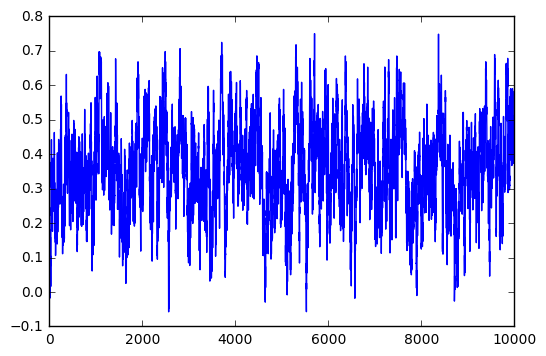

In [41]:
plt.plot(a[:,0])
plt.show()

In [44]:
%timeit funcs.stogradU_logistic(theta, Y, Xs, nbatch, phi)

10000 loops, best of 3: 44.7 µs per loop


In [7]:
funcs.test(np.arange(10), 10, 10)

array([ 9.,  0.,  8.,  5.,  6.,  4.,  1.,  2.,  3.,  7.])

In [35]:
funcs.mvnorm(np.zeros(p), np.identity(p), 1)

array([[-0.87385359, -0.16941901,  1.16995939, -0.4362486 , -0.46240708,
         1.63181025, -0.09875277,  1.03700719]])

### Python

In [28]:
samples, H = run_sghmc(Y, Xs, U_logistic, gradU_logistic, M, eps, m, np.zeros(p), C, V, phi, nsample)

np.mean(samples, axis=0)

array([ 0.36914602,  1.01212955, -0.20703302,  0.0011857 , -0.12589658,
        0.55628479,  0.33929519,  0.14644641])

In [46]:
%timeit run_sghmc(Y, Xs, U_logistic, gradU_logistic, M, eps, m, np.zeros(p), C, V, phi, nsample)

1 loop, best of 3: 55.8 s per loop


In [45]:
%timeit stogradU(theta, Y, Xs, nbatch, phi)

10000 loops, best of 3: 108 µs per loop


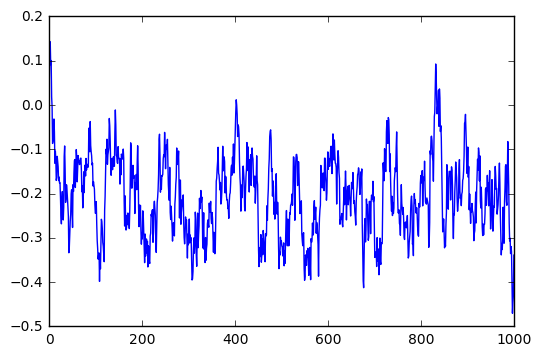

In [29]:
plt.plot((samples)[:,2])
plt.show()